## Libraries

In [1]:
%config Completer.use_jedi = False
import warnings; warnings.simplefilter('ignore')
import logging, sys
logging.disable(sys.maxsize)
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('mode.chained_assignment',None)
import numpy as np
import matplotlib.pyplot as plt
import copy
from datetime import datetime,timedelta
import time
import csv

import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

## Tensorflow and Keras libraries

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

mem = int(2 * 1024)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=mem)])

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Activation, Dense
from tensorflow.keras.optimizers import Adam
tf.__version__

Num GPUs Available:  1


'2.1.0'

# Single layer RNN

In [3]:
def DL_1(size, h1):

    model = Sequential()
    model.add(Bidirectional(GRU(h1, 
                 activation="relu", return_sequences=False),
                 input_shape=(size[1], size[2]) ))
    model.add(Dense(6, name='out_layer')) #multi-output, i.e., 6 regions

    return model

## Method for time-series transformation

In [4]:
def series_to_supervised(data, lag=1, step_ahead=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data if isinstance(data, pd.DataFrame) else pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(lag, 0, -1):
        cols.append(df.shift(i))
        names += [str(df.columns[j])+'_(t-%d)' % (i) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, step_ahead):
        cols.append(df.shift(-i))
        if i == 0:
            names += [str(df.columns[j])+'_(t)' for j in range(n_vars)]
        else:
            names += [str(df.columns[j])+'_(t+%d)' % (i) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Reading real data

In [5]:
df = pd.read_csv('ML/ML_final_df_real.csv', parse_dates=True, squeeze=True)
print(len(np.unique(df['Date'])))

indexing = pd.Series(df["Date"] + ' ' + df["Hour"]).values
df['Date_time'] = pd.to_datetime(indexing)

date_time = pd.to_datetime(df.pop('Date_time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
month = 30 * day
week = 7 * day
year = (365.2425)*day

df['Day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Week_sin'] = np.sin(timestamp_s * (2 * np.pi / month))
df['Week_cos'] = np.cos(timestamp_s * (2 * np.pi / month))
# df['Year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
# df['Year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))
# df['Month_sin'] = np.sin(timestamp_s * (2 * np.pi / month))
# df['Month_cos'] = np.cos(timestamp_s * (2 * np.pi / month))

org_col = ['Date', 'Hour', 
           'Day_sin', 'Day_cos', 
           'Week_sin', 'Week_cos',
#            'Year_sin', 'Year_cos',
#            'Month_sin', 'Month_cos',            
           'Total']
regions = [
            'Commune Montreuil', 
            'IRIS 930480204', 
            'IRIS 930480205',
            'IRIS 930480206', 
            'IRIS 930480401', 
            'IRIS 930480604'
            ]
df = copy.deepcopy(df[org_col+regions])
del df['Date']
del df['Hour']
del df['Total']
df

72


,Day_sin,Day_cos,Week_sin,Week_cos,Commune Montreuil,IRIS 930480204,IRIS 930480205,IRIS 930480206,IRIS 930480401,IRIS 930480604
0,-1.184929e-11,1.000000,-0.587785,-0.809017,100209,9885,11802,8783,2893,9076
1,1.305262e-01,0.991445,-0.591310,-0.806445,95213,11148,12184,8286,2895,9034
2,2.588190e-01,0.965926,-0.594823,-0.803857,85383,9647,9769,6320,1681,8104
3,3.826834e-01,0.923880,-0.598325,-0.801254,79010,6530,12188,6967,2413,8333
4,5.000000e-01,0.866025,-0.601815,-0.798636,74321,7071,12501,5720,2812,1696
...,...,...,...,...,...,...,...,...,...,...
3451,-6.087614e-01,0.793353,0.186524,0.982450,133185,15202,18054,12558,5878,11029
3452,-5.000000e-01,0.866025,0.190809,0.981627,130355,14192,17026,11415,4886,9862
3453,-3.826834e-01,0.923880,0.195090,0.980785,131729,15233,17023,11529,4751,10196
3454,-2.588190e-01,0.965926,0.199368,0.979925,127616,14404,16081,11024,5296,10317


## Static parameters

In [6]:
np.random.seed(42)

#number of evaluations due to randomness
nb_seed = 1 #we runned 10x
print('The models will run {}x due to randomness'.format(nb_seed))

n_l = 3120 #Train shape + lag (3114 + 6)
print('# training samples:', n_l)## Static parameters

EPOCHS = 10 #we trained over 100 epochs

The models will run 1x due to randomness
# training samples: 3120


## Number of lags and time steps ahead

In [7]:
lag = 6
step_ahead = 1
reframed = series_to_supervised(df, lag, step_ahead)
reframed.head(5)

,Day_sin_(t-6),Day_cos_(t-6),Week_sin_(t-6),Week_cos_(t-6),Commune Montreuil_(t-6),IRIS 930480204_(t-6),IRIS 930480205_(t-6),IRIS 930480206_(t-6),IRIS 930480401_(t-6),IRIS 930480604_(t-6),Day_sin_(t-5),Day_cos_(t-5),Week_sin_(t-5),Week_cos_(t-5),Commune Montreuil_(t-5),IRIS 930480204_(t-5),IRIS 930480205_(t-5),IRIS 930480206_(t-5),IRIS 930480401_(t-5),IRIS 930480604_(t-5),Day_sin_(t-4),Day_cos_(t-4),Week_sin_(t-4),Week_cos_(t-4),Commune Montreuil_(t-4),...,IRIS 930480204_(t-2),IRIS 930480205_(t-2),IRIS 930480206_(t-2),IRIS 930480401_(t-2),IRIS 930480604_(t-2),Day_sin_(t-1),Day_cos_(t-1),Week_sin_(t-1),Week_cos_(t-1),Commune Montreuil_(t-1),IRIS 930480204_(t-1),IRIS 930480205_(t-1),IRIS 930480206_(t-1),IRIS 930480401_(t-1),IRIS 930480604_(t-1),Day_sin_(t),Day_cos_(t),Week_sin_(t),Week_cos_(t),Commune Montreuil_(t),IRIS 930480204_(t),IRIS 930480205_(t),IRIS 930480206_(t),IRIS 930480401_(t),IRIS 930480604_(t)
6,-1.184929e-11,1.000000,-0.587785,-0.809017,100209.0,9885.0,11802.0,8783.0,2893.0,9076.0,0.130526,0.991445,-0.591310,-0.806445,95213.0,11148.0,12184.0,8286.0,2895.0,9034.0,0.258819,0.965926,-0.594823,-0.803857,85383.0,...,7071.0,12501.0,5720.0,2812.0,1696.0,0.608761,0.793353,-0.605294,-0.796002,72135.0,7320.0,13194.0,5517.0,3039.0,1430.0,0.707107,0.707107,-0.608761,-0.793353,71303,6902,13416,6355,3047,1427
7,1.305262e-01,0.991445,-0.591310,-0.806445,95213.0,11148.0,12184.0,8286.0,2895.0,9034.0,0.258819,0.965926,-0.594823,-0.803857,85383.0,9647.0,9769.0,6320.0,1681.0,8104.0,0.382683,0.923880,-0.598325,-0.801254,79010.0,...,7320.0,13194.0,5517.0,3039.0,1430.0,0.707107,0.707107,-0.608761,-0.793353,71303.0,6902.0,13416.0,6355.0,3047.0,1427.0,0.793353,0.608761,-0.612217,-0.790690,68022,7376,13309,5892,2641,1335
8,2.588190e-01,0.965926,-0.594823,-0.803857,85383.0,9647.0,9769.0,6320.0,1681.0,8104.0,0.382683,0.923880,-0.598325,-0.801254,79010.0,6530.0,12188.0,6967.0,2413.0,8333.0,0.500000,0.866025,-0.601815,-0.798636,74321.0,...,6902.0,13416.0,6355.0,3047.0,1427.0,0.793353,0.608761,-0.612217,-0.790690,68022.0,7376.0,13309.0,5892.0,2641.0,1335.0,0.866025,0.500000,-0.615661,-0.788011,64955,6898,12983,7172,2942,1213
9,3.826834e-01,0.923880,-0.598325,-0.801254,79010.0,6530.0,12188.0,6967.0,2413.0,8333.0,0.500000,0.866025,-0.601815,-0.798636,74321.0,7071.0,12501.0,5720.0,2812.0,1696.0,0.608761,0.793353,-0.605294,-0.796002,72135.0,...,7376.0,13309.0,5892.0,2641.0,1335.0,0.866025,0.500000,-0.615661,-0.788011,64955.0,6898.0,12983.0,7172.0,2942.0,1213.0,0.923880,0.382683,-0.619094,-0.785317,63763,2777,8483,7328,1992,1225
10,5.000000e-01,0.866025,-0.601815,-0.798636,74321.0,7071.0,12501.0,5720.0,2812.0,1696.0,0.608761,0.793353,-0.605294,-0.796002,72135.0,7320.0,13194.0,5517.0,3039.0,1430.0,0.707107,0.707107,-0.608761,-0.793353,71303.0,...,6898.0,12983.0,7172.0,2942.0,1213.0,0.923880,0.382683,-0.619094,-0.785317,63763.0,2777.0,8483.0,7328.0,1992.0,1225.0,0.965926,0.258819,-0.622515,-0.782608,64204,2381,8401,7242,1653,1211


## Split into train and test sets

In [8]:
reframed_values = reframed.values

size_val = 0 #size of validation set
size_test = 7*48 #size of test set equal seven days (i.e., last week)

# val = reframed_values[0:size_val, :] #we'll not use a validation set
train = reframed_values[size_val:-size_test, :]
test = reframed_values[-size_test:, :]
print("Train shape: ", train.shape,", Test shape: ", test.shape)

# split into input and outputs
n_features = df.shape[1]
n_targets = len(regions) 
# x_val, y_val = val[:,:-n_features], val[:,-n_targets:] 
x_train, y_train = train[:,:-n_features], train[:,-n_targets:]
x_test, y_test = test[:,:-n_features], test[:,-n_targets:]

print("x_train shape: ", x_train.shape, ', y_train shape', y_train.shape, ", x_test shape: ", x_test.shape, ', y_test shape', y_test.shape)

# reshape input to be 3D [samples, lag, features]
# x_val = x_val.reshape( (x_val.shape[0], lag , n_features) )
x_train = x_train.reshape( (x_train.shape[0], lag , n_features) )
x_test = x_test.reshape( (x_test.shape[0], lag , n_features) )

print("x_train shape: ", x_train.shape, ", x_test shape: ", x_test.shape)

Train shape:  (3114, 70) , Test shape:  (336, 70)
x_train shape:  (3114, 60) , y_train shape (3114, 6) , x_test shape:  (336, 60) , y_test shape (336, 6)
x_train shape:  (3114, 6, 10) , x_test shape:  (336, 6, 10)


## Baseline: persistence model, i.e., X(t+1) = X(t)

In [9]:
base_pred = df[regions][-size_test-1:-1] 
base_pred.reset_index(inplace=True, drop=True)

rmse_region = np.sqrt(mean_squared_error(y_test, base_pred, multioutput='raw_values'))
rmse_mean = np.mean(rmse_region)
rmse_std = np.std(rmse_region)

mae_region = mean_absolute_error(y_test, base_pred, multioutput='raw_values')
mae_mean = np.mean(mae_region)
mae_std = np.std(mae_region)

print("Baseline RMSE mean: ", round(rmse_mean,1), ", Baseline MAE mean:", round(mae_mean,1))

Baseline RMSE mean:  1503.6 , Baseline MAE mean: 1107.1


## Objective function for Bayesian optimization

In [10]:
def objective_function(space):
    """
    intput: Search space of hyperparameters.
    output: Loss value.
    """
    
    global ITER, x_train, y_train, x_test, y_test, EPOCHS, nb_seed
    
    ITER += 1
    
    #selecting parameters of Bayesian optimization
    params = {"LR" : round(space["LR"], 6), 
              "BS" : int(space["BS"]), 
              "h1" : int(space["h1"])
             }
    
    print("\niter:", ITER, "params ", params)
    
    #due to randomness, take the mean loss of the models over nb_seed runs. 
    lst_loss = []
    for SEED in range(nb_seed):

        #Instantiate the RNN model
        model = DL_1(x_train.shape, params["h1"])

        #non-DP optimizer
        model.compile(loss = "mean_absolute_error", 
                      optimizer = Adam(learning_rate=params["LR"]), 
                     )  
        model.fit(x = x_train, 
                  y = y_train,
                  batch_size = params["BS"], 
                  epochs = EPOCHS, 
                  verbose = 0,
                  shuffle = False)

        #prediction
        y_pred = model.predict(x_test)
        y_pred = y_pred.clip(0) #post-process to ensure non-negativity

        #save predictions for reproducibility (or .h5 values)
#     np.save("file_name.npy", y_pred)

        #calculate rmse metric, mean and std value
        rmse_region = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
        rmse_mean = np.mean(rmse_region)
        rmse_std = np.std(rmse_region)
    
        #the loss function for Bayesian optimization
        loss = round(rmse_mean + rmse_std , 4)
        lst_loss.append(loss)
    
    mean_loss = np.mean(lst_loss)
    print("Averaged loss:", mean_loss)
        
    return {'loss': mean_loss, 'status': STATUS_OK}

## Bayesian Optimization

In [11]:
# defining search space
space = {
    "LR": hp.uniform('LR', 1e-5, 3e-3), #learning rate
    "BS": hp.quniform('BS', 5, 40, 5), #batch size
    "h1": hp.quniform('h1', 25, 500, 25), #number of neurons of first hidden layer
}

#Number of iterations for Bayesian optimization
NB_ITER = 1 #we runned 100

#Bayesian optimization
ITER = 0
trials = Trials()
best = fmin(fn=objective_function,
            space=space,
            algo=tpe.suggest,
            rstate= np.random.RandomState(42), 
            max_evals=NB_ITER, #
            verbose=False,
            trials=trials)
print("Best Hyperparameters:", best)


iter: 1 params  {'LR': 0.0025, 'BS': 5, 'h1': 250}
Averaged loss: 2156.2177
Best Hyperparameters: {'BS': 5.0, 'LR': 0.0024995697766217297, 'h1': 250.0}


## Best Resul

In [12]:
#saving results
dic_rmse = {SEED: [] for SEED in range(nb_seed)}
dic_mae = {SEED: [] for SEED in range(nb_seed)}

#Take best hyperparameters from Bayesian optimization
BATCH_SIZE = int(best["BS"])
h1 = int(best['h1'])
LEARNING_RATE = round(best['LR'], 6)

#due to randomness, take the results of the best model over nb_seed runs. 
for SEED in range(nb_seed):
    
    #Instantiate the RNN model
    model = DL_1(x_train.shape, h1)
    
    #non-DP optimizer
    model.compile(loss = "mean_absolute_error", 
                  optimizer = Adam(learning_rate=LEARNING_RATE), 
                 )  
    model.fit(x = x_train, 
              y = y_train,
              batch_size = BATCH_SIZE, 
              epochs = EPOCHS, 
              verbose = 0,
              shuffle = False)

    #prediction
    y_pred = model.predict(x_test)
    y_pred = y_pred.clip(0) #post-process to ensure non-negativity
    
    #calculate rmse metric, mean and std value
    rmse_region = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
    rmse_mean = np.mean(rmse_region)
    rmse_std = np.std(rmse_region)
    
    #calculate mae metric, mean and std value
    mae_region = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    mae_mean = np.mean(mae_region)
    mae_std = np.std(mae_region)
    
    dic_rmse[SEED].append(rmse_region)
    dic_mae[SEED].append(mae_region)
    
    #save predictions for reproducibility (or .h5 values)
#     np.save("file_name.npy", y_pred)
    
    print("RMSE mean: ", rmse_mean, "\tMAE mean:", mae_mean)
    print('------------------------------------------------------------------------\n')

RMSE mean:  1393.239440995182 	MAE mean: 1086.816510457841
------------------------------------------------------------------------



In [13]:
print('Average RMSE per SEED:', [dic_rmse[i][0].mean() for i in range(nb_seed)])

Average RMSE per SEED: [1393.239440995182]


## Ploting

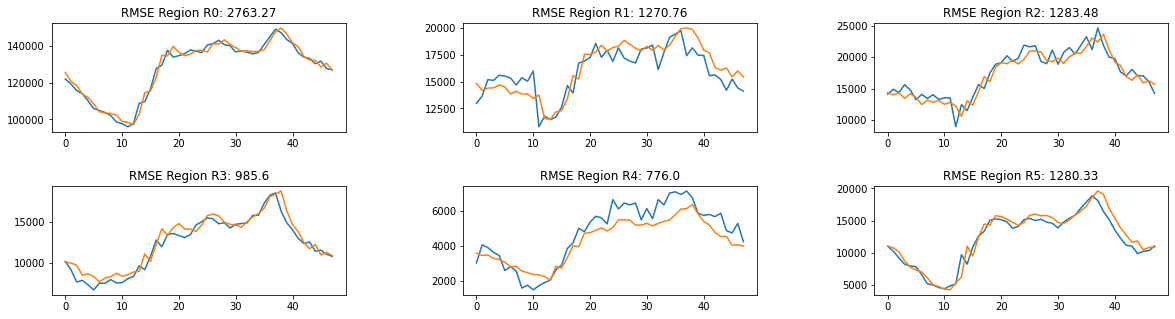

In [14]:
# illustrative example with only 10 epochs and a single execution
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.5)
row, col = 0, 0
show = 48*1
for i in range(6):
    ax[row,col].plot(np.arange(show), y_test[-show:,i], label="true")
    ax[row,col].plot(np.arange(show), y_pred[-show:,i], label="pred")
    ax[row,col].set_title("RMSE Region R"+str(i)+": "+str(round(rmse_region[i],2)))
    if col<2:
        col+=1
    else:
        col=0
        row += 1
plt.show()